<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

<Ответ>

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

<Ответ>

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

<Ответ>

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

<Ответ>


**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

<Ответ>

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

<Ответ>

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
!wget https://www.dropbox.com/s/d50pqlm19c6f6w5/data.tar.gz?dl=0 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-05-02 13:40:03--  https://www.dropbox.com/s/d50pqlm19c6f6w5/data.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/iIN64S1vVnwPsSpKWWeWjDLulxV7DDwgqU8C3rBQEOmydQIRjF2Tt59FYu6wzo3m/file [following]
--2017-05-02 13:40:03--  https://dl.dropboxusercontent.com/content_link/iIN64S1vVnwPsSpKWWeWjDLulxV7DDwgqU8C3rBQEOmydQIRjF2Tt59FYu6wzo3m/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506221998 (483M) [application/octet-stream]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 482.77M  46.5MB/s    in 10s     

2017-05-02 13:40:15 (47.0 MB/s) - ‘data.tar.gz’ saved [5062

### Data preprocessing

In [152]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 4.42 s, sys: 440 ms, total: 4.86 s
Wall time: 4.86 s


In [118]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [119]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [120]:
# Build a Vocabulary

from collections import Counter

############# TO CODE IT BY YOURSELF ##################
word_counts = Counter()
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        for word in captions[img_i][caption_i]:
            word_counts[word] += 1

vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [121]:
print word_counts

Counter({u'a': 1019785, '#END#': 616767, '#START#': 616767, u'on': 224758, u'of': 212689, u'the': 206178, u'in': 191793, u'with': 161216, u'and': 146755, u'is': 102390, u'man': 75957, u'to': 71183, u'sitting': 55190, u'an': 51987, u'two': 50467, u'at': 44506, u'standing': 44297, u'people': 43707, u'are': 42776, u'next': 38867, u'white': 37898, u'woman': 35372, u'street': 31572, u'table': 31444, u'that': 29168, u'holding': 29106, u'large': 25614, u'it': 25608, u'person': 25432, u'some': 25385, u'down': 24038, u'top': 23254, u'group': 22551, u'up': 22425, u'field': 21659, u'small': 20892, u'tennis': 20556, u'near': 20432, u'front': 20342, u'black': 20288, u'his': 20242, u'train': 19464, u'plate': 19183, u'room': 19067, u'riding': 18841, u'dog': 18839, u'red': 18110, u'cat': 17908, u'young': 17804, u'by': 17762, u'water': 17096, u'baseball': 16323, u'has': 15818, u'playing': 15354, u'while': 15278, u'walking': 15182, u'bathroom': 15036, u'sign': 14666, u'blue': 14340, u'kitchen': 13917, u

In [122]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [123]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,  3980,  6254,  8134,    -1,    -1],
       [ 8481,  6766,  1243,  8902,  1021,  9095,  6254,  3980,  8256,
          727,  5915,  8134,    -1,    -1,    -1],
       [ 8481,  8717,  4136, 10058,  9934,  5915,  4859,  6766,  5627,
         8639,   535,  5470,  7115,  5155,  8134],
       [ 8481,  8717,  8897,  3069,  2538,   781,  8717,  8897,  1558,
         8134,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,   535,  5470,  8919,  8134,    -1]], dtype=int32)

### Mah Neural Network

In [124]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 512 #pls change me if u want
LSTM_UNITS = 512 #pls change me if u want

In [125]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

In [126]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [127]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################

#EmbeddingLayer(incoming, input_size, output_size, W=lasagne.init.Normal(), **kwargs)
l_word_embeddings = EmbeddingLayer(l_words, len(vocab), EMBED_SIZE)

In [128]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there

#l_image_features_small = DropoutLayer(l_image_features, p=0.3)
l_image_features_small = DropoutLayer(l_image_features, p=0.5)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [129]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
#class lasagne.layers.LSTMLayer(incoming, 
#                               num_units,  
#                               cell_init=lasagne.init.Constant(0.), #Initializer for initial cell state (c0c0).
#                               grad_clipping=0, 
# If nonzero, the gradient messages are clipped to the given value during the backward pass.
#                               mask_input=None)
# Layer which allows for a sequence mask to be input, for when sequences are of variable length. 


decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=100)

In [130]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 512)
output shape =  (None, None, 10373)


In [131]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
#loss = <mean over non-PAD tokens>
loss = (loss.reshape(reference_answers.shape)*output_mask).sum() / output_mask.sum()

In [132]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
weights = get_all_params(predicted_probabilities, trainable=True)
updates = lasagne.updates.adam(loss, params=weights)
#eta = theano.shared(lasagne.utils.floatX(0.001))
#updates = lasagne.updates.sgd(loss, params=weights, learning_rate=eta)
print weights

[W, W, b, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W, b]


In [133]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################

train_step = theano.function([image_vectors, sentences],
                             loss, updates=updates, allow_input_downcast=True)

val_step = theano.function([image_vectors, sentences],
                             loss, allow_input_downcast=True)

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [134]:
captions = np.array(captions)

In [135]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [136]:
generate_batch(img_codes,captions, 3)

(array([[-2.78535461, -3.17264104,  0.59226346, ..., -4.21059752,
          0.22307819,  0.54246163],
        [ 1.74981391,  0.23733702,  1.239447  , ..., -1.64053822,
         -2.67704678,  0.95501435],
        [-0.71595216,  2.10309935,  0.61526823, ..., -0.86304718,
         -0.17379051,  2.11649275]], dtype=float32),
 array([[ 8481,  2852,  9806,   706,  9993,   760,  2384,  8717,  5480,
          5377,  8134,    -1],
        [ 8481,  8717,  7187, 10058,  6766,  7562,  2603,  3069,  3980,
          3323,  3601,  8134],
        [ 8481,  8717,  6032,  2961,   781,  8544,   781,  8717,  5400,
          9569,  8134,    -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [137]:
batch_size = 100 #adjust me
n_epochs   = 200 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 10 #how many batches are used for validation after each epoch

In [138]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0, train loss: 6.05299341202, val loss: 5.13879947662


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 1, train loss: 4.90948429108, val loss: 4.60620503426


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 4.36438326359, val loss: 4.13624973297


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 3, train loss: 4.03047019005, val loss: 3.87382845879


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 3.82847859383, val loss: 3.77584245205


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 3.65890803814, val loss: 3.63599534035


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 6, train loss: 3.54731293678, val loss: 3.50694797039


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 7, train loss: 3.5011783886, val loss: 3.35996553898


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 8, train loss: 3.38813055515, val loss: 3.32034201622


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 9, train loss: 3.37745542526, val loss: 3.29712080956


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 10, train loss: 3.28064061642, val loss: 3.27954800129


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 11, train loss: 3.2170899868, val loss: 3.13403310776


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 12, train loss: 3.2029699564, val loss: 3.14992902279


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.19985480785, val loss: 3.1938256979


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.1301050806, val loss: 3.10774307251


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 15, train loss: 3.08259430885, val loss: 3.09554748535


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 16, train loss: 3.07312381268, val loss: 3.02268459797


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.03817202091, val loss: 3.02701935768


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.02311640263, val loss: 2.98904240131


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 19, train loss: 2.9898889637, val loss: 3.01063673496


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 20, train loss: 2.9668757534, val loss: 2.95866839886


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 21, train loss: 2.95163665771, val loss: 2.90064964294


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 22, train loss: 2.94971322536, val loss: 2.99317069054


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 2.93389158726, val loss: 2.92171573639


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 24, train loss: 2.9129380703, val loss: 2.81299459934


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 25, train loss: 2.91808252335, val loss: 2.8979516983


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 26, train loss: 2.92449669838, val loss: 2.88519558907


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 27, train loss: 2.89235637188, val loss: 2.88619093895


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 28, train loss: 2.85875841618, val loss: 2.86880443096


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 29, train loss: 2.83677293777, val loss: 2.81583929062


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 30, train loss: 2.83205429077, val loss: 2.82559010983


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 31, train loss: 2.77892529964, val loss: 2.84789876938


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 2.78321388721, val loss: 2.81141633987


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 33, train loss: 2.82866698265, val loss: 2.75707814693


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 34, train loss: 2.78717852116, val loss: 2.81964440346


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 35, train loss: 2.81020530701, val loss: 2.85731129646


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 36, train loss: 2.77720879078, val loss: 2.81422569752


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 37, train loss: 2.75978050709, val loss: 2.77216236591


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 38, train loss: 2.75592779636, val loss: 2.75335717201


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 39, train loss: 2.73654643059, val loss: 2.72933130264


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 40, train loss: 2.7322158432, val loss: 2.75385704041


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 41, train loss: 2.74672689438, val loss: 2.72841355801


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 42, train loss: 2.74174919605, val loss: 2.70895059109


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 43, train loss: 2.7170361948, val loss: 2.74260087013


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 44, train loss: 2.72231203079, val loss: 2.69082212448


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 45, train loss: 2.73681672096, val loss: 2.75324048996


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 46, train loss: 2.7129639101, val loss: 2.70217151642


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 47, train loss: 2.70343646049, val loss: 2.7455337286


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 48, train loss: 2.68519708157, val loss: 2.68041903973


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 49, train loss: 2.69544167995, val loss: 2.66330535412


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 50, train loss: 2.68559251785, val loss: 2.63685925007


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 51, train loss: 2.67127858162, val loss: 2.71457929611


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 52, train loss: 2.65869688988, val loss: 2.66003220081


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 53, train loss: 2.64785887241, val loss: 2.60738723278


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 54, train loss: 2.66446071625, val loss: 2.61669225693


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 55, train loss: 2.63300756454, val loss: 2.64062855244


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 56, train loss: 2.64766814232, val loss: 2.65908908844


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 57, train loss: 2.63359183311, val loss: 2.6349968195


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 58, train loss: 2.62769991398, val loss: 2.64390838146


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 59, train loss: 2.64143060207, val loss: 2.65720083714


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 60, train loss: 2.6311593771, val loss: 2.57941446304


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 61, train loss: 2.61416481018, val loss: 2.58924603462


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 62, train loss: 2.63747307301, val loss: 2.65560166836


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 63, train loss: 2.6193350172, val loss: 2.61011388302


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 64, train loss: 2.61932229042, val loss: 2.67476341724


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 65, train loss: 2.61540344715, val loss: 2.62289590836


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 66, train loss: 2.6147169733, val loss: 2.60820045471


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 67, train loss: 2.59428019524, val loss: 2.6065182209


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 68, train loss: 2.5965066576, val loss: 2.55819880962


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 69, train loss: 2.57878460407, val loss: 2.60896675587


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 70, train loss: 2.58794023514, val loss: 2.57829942703


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 71, train loss: 2.59055119991, val loss: 2.57139921188


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 72, train loss: 2.57961576462, val loss: 2.54058744907


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 73, train loss: 2.57129849911, val loss: 2.62984809875


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 74, train loss: 2.58895203114, val loss: 2.52233531475


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 75, train loss: 2.56425446987, val loss: 2.55761363506


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 76, train loss: 2.56144546032, val loss: 2.56895956993


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 77, train loss: 2.53823644638, val loss: 2.5652794838


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 78, train loss: 2.56045428276, val loss: 2.64414103031


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 79, train loss: 2.57426622868, val loss: 2.58304064274


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 80, train loss: 2.52827187061, val loss: 2.56630289555


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 81, train loss: 2.54232965469, val loss: 2.56585986614


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 82, train loss: 2.52464251995, val loss: 2.52787790298


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 83, train loss: 2.54197639942, val loss: 2.57741966248


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 84, train loss: 2.56682932377, val loss: 2.54240641594


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 85, train loss: 2.52552918434, val loss: 2.50076973438


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 86, train loss: 2.53391794205, val loss: 2.57881202698


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 87, train loss: 2.52022045135, val loss: 2.57500560284


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 88, train loss: 2.51653024197, val loss: 2.50980911255


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 89, train loss: 2.55647789955, val loss: 2.5495541811


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 90, train loss: 2.5071031332, val loss: 2.52374565601


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 91, train loss: 2.52691255569, val loss: 2.53316400051


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 92, train loss: 2.52694296837, val loss: 2.52404823303


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 93, train loss: 2.51732466698, val loss: 2.54213011265


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 94, train loss: 2.51409629345, val loss: 2.49756851196


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 95, train loss: 2.50517900467, val loss: 2.51011734009


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 96, train loss: 2.49387521744, val loss: 2.48738646507


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 97, train loss: 2.49113519669, val loss: 2.50723176003


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 98, train loss: 2.49223630428, val loss: 2.48991014957


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 99, train loss: 2.4951971674, val loss: 2.48850193024


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 100, train loss: 2.4766053915, val loss: 2.53008847237


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 101, train loss: 2.5247516346, val loss: 2.48402934074


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 102, train loss: 2.49650246143, val loss: 2.47621130943


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 103, train loss: 2.49249211311, val loss: 2.50321242809


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 104, train loss: 2.48068926334, val loss: 2.49068667889


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 105, train loss: 2.47356781483, val loss: 2.5654225111


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 106, train loss: 2.48302619934, val loss: 2.43171441555


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 107, train loss: 2.48161231041, val loss: 2.48180301189


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 108, train loss: 2.45812707901, val loss: 2.40617785454


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 109, train loss: 2.47553504944, val loss: 2.46762406826


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 110, train loss: 2.45827603817, val loss: 2.47788054943


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 111, train loss: 2.48133495331, val loss: 2.48077421188


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 112, train loss: 2.4671645689, val loss: 2.45612235069


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 113, train loss: 2.47450713158, val loss: 2.5069914341


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 114, train loss: 2.44624226093, val loss: 2.46613588333


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 115, train loss: 2.46169347763, val loss: 2.50105237961


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 116, train loss: 2.48462369442, val loss: 2.47405776978


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 117, train loss: 2.46199682713, val loss: 2.49647638798


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 118, train loss: 2.44872551441, val loss: 2.48366639614


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 119, train loss: 2.45419667244, val loss: 2.46599166393


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 120, train loss: 2.44892898083, val loss: 2.41561300755


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 121, train loss: 2.44034012794, val loss: 2.47708506584


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 122, train loss: 2.44889165878, val loss: 2.47600495815


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 123, train loss: 2.44019658089, val loss: 2.42746720314


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 124, train loss: 2.47309933186, val loss: 2.46966965199


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 125, train loss: 2.44105138302, val loss: 2.47516460419


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 126, train loss: 2.45082486153, val loss: 2.47091543674


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 127, train loss: 2.42675456524, val loss: 2.40983262062


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 128, train loss: 2.44893298149, val loss: 2.42361662388


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 129, train loss: 2.43500435352, val loss: 2.38407638073


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 130, train loss: 2.42840978622, val loss: 2.41442098618


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 131, train loss: 2.43797626019, val loss: 2.45848767757


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 132, train loss: 2.45210766315, val loss: 2.45232646465


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 133, train loss: 2.4354083395, val loss: 2.42951490879


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 134, train loss: 2.43182512283, val loss: 2.43064045906


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 135, train loss: 2.4330932188, val loss: 2.43493452072


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 136, train loss: 2.45229482651, val loss: 2.48362402916


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 137, train loss: 2.42376448631, val loss: 2.42103922367


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 138, train loss: 2.42630815983, val loss: 2.41514964104


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 139, train loss: 2.42037398338, val loss: 2.44114692211


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 140, train loss: 2.43187524319, val loss: 2.40633027554


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 141, train loss: 2.41145803452, val loss: 2.43821339607


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 142, train loss: 2.43736598015, val loss: 2.40276100636


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 143, train loss: 2.40508129597, val loss: 2.4388471365


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 144, train loss: 2.40186311245, val loss: 2.45515229702


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 145, train loss: 2.4347132206, val loss: 2.38439512253


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 146, train loss: 2.43656646729, val loss: 2.3789681673


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 147, train loss: 2.42288288116, val loss: 2.38444926739


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 148, train loss: 2.41289638042, val loss: 2.33555011749


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 149, train loss: 2.3995182848, val loss: 2.36677026749


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 150, train loss: 2.4010523653, val loss: 2.38950781822


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 151, train loss: 2.39132052422, val loss: 2.35797286034


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 152, train loss: 2.40075549603, val loss: 2.38240156174


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 153, train loss: 2.38231834412, val loss: 2.39011356831


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 154, train loss: 2.40171205044, val loss: 2.38476653099


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 155, train loss: 2.39649740696, val loss: 2.45296788216


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 156, train loss: 2.38399489403, val loss: 2.39827871323


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 157, train loss: 2.38292800426, val loss: 2.37255029678


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 158, train loss: 2.40798914909, val loss: 2.36665935516


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 159, train loss: 2.3812108326, val loss: 2.42748651505


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 160, train loss: 2.37986633778, val loss: 2.37858290672


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 161, train loss: 2.37085125446, val loss: 2.36105937958


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 162, train loss: 2.36611506462, val loss: 2.41370716095


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 163, train loss: 2.36266094208, val loss: 2.39004318714


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 164, train loss: 2.37441144943, val loss: 2.35432069302


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 165, train loss: 2.36143064499, val loss: 2.34862487316


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 166, train loss: 2.38964304447, val loss: 2.40240457058


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 167, train loss: 2.39910991669, val loss: 2.35174365044


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 168, train loss: 2.38944040298, val loss: 2.36408786774


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 169, train loss: 2.3769666338, val loss: 2.38277103901


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 170, train loss: 2.38960394382, val loss: 2.37902719975


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 171, train loss: 2.41236877918, val loss: 2.38150851727


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 172, train loss: 2.37328956127, val loss: 2.41344585419


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 173, train loss: 2.34669676304, val loss: 2.32433271408


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 174, train loss: 2.35453983784, val loss: 2.34321987629


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 175, train loss: 2.37951761723, val loss: 2.40460793972


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 176, train loss: 2.35471288204, val loss: 2.41023979187


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 177, train loss: 2.3629964304, val loss: 2.41559123993


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 178, train loss: 2.37543161869, val loss: 2.3592394352


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 179, train loss: 2.35861692905, val loss: 2.36100125313


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 180, train loss: 2.35283375263, val loss: 2.32320270538


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 181, train loss: 2.36590114594, val loss: 2.33453550339


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 182, train loss: 2.36574767113, val loss: 2.34789977074


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 183, train loss: 2.35714895725, val loss: 2.34808497429


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 184, train loss: 2.35755656242, val loss: 2.37743091583


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 185, train loss: 2.36429335594, val loss: 2.39914219379


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 186, train loss: 2.38390348434, val loss: 2.3642901659


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 187, train loss: 2.36892580509, val loss: 2.3259704113


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 188, train loss: 2.36079891205, val loss: 2.31377637386


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 189, train loss: 2.34948283672, val loss: 2.3382153511


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 190, train loss: 2.31667091846, val loss: 2.36303601265


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 191, train loss: 2.32780941486, val loss: 2.36122310162


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 192, train loss: 2.32662698269, val loss: 2.43330614567


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 193, train loss: 2.35436792374, val loss: 2.34775202274


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 194, train loss: 2.32899525642, val loss: 2.36930963993


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 195, train loss: 2.3478840971, val loss: 2.35188469887


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 196, train loss: 2.34727336884, val loss: 2.30943305492


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 197, train loss: 2.33744354248, val loss: 2.32452955246


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 198, train loss: 2.3323103857, val loss: 2.33043603897


100%|██████████| 50/50 [00:23<00:00,  1.78it/s]



Epoch: 199, train loss: 2.32951896191, val loss: 2.29880414009
Finish :)


### apply trained model

In [139]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [140]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

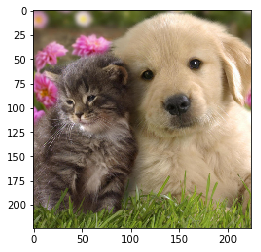

In [141]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [142]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

Params:

batch_size = 50, 
n_epochs   = 100, n_batches_per_epoch = 50, n_validation_batches = 5



The best results:

- a white and black cat on a green field
- a brown and white cat sitting on a white and green field

In [82]:
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

two small three brown cats put together on a plate
atmosphere point with a flower and a striped cat
a dog is sitting on a blue bench in front of a chair
small children look down at christmas animals of a window
small black looking up a picture of a dog on a dotted table
older woman with a little little girl sitting in front of it in front of a dog
with a really nice looking over a small sheep
an image of two brown and white photograph of a cat in a box
is a white cat that is sitting in front of a window
wooden #UNK# looking like a sheep at a big grass covered field


In [80]:
for i in range(10):
    print ' '.join(generate_caption(img,t=2.)[1:-1])

small white and white photo of a cat on a chair
two cats sitting on a big piece of wood
this #UNK# is a #UNK# with a cat
a white and black cat on a green field
a black and white cat sitting on a couch
a small white and black cat on a green field
cow with a black and white striped jacket
a woman holding a small dog in his hands
there is a white cat sitting on a blue rug
two cats sitting on a wooden bench


In [84]:
for i in range(10):
    print ' '.join(generate_caption(img,t=2.5)[1:-1])

a gray and white cat sitting on a chair
a white and white photo of a dog and a cat
a small white cat is sitting on a black and white plate
a white and black cat with a white collar
a small brown and white cat is sitting on a couch
a small white and grey cat is sitting on a bench
a brown and white cat sitting on a white and green field
a large brown and white cat is sitting on a bench
a small white and white cat in a green field
a little girl with a blue coat and a cat


Params:

batch_size = 100, 
n_epochs   = 200, n_batches_per_epoch = 50, n_validation_batches = 10



The best results:

- a black and white cat laying in a green grass field
- a little white dog laying on top of a green blanket

In [143]:
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

two two white cats on some red grass next to each other
white furry orange and sleeping brown and white cat is laying in the grass
a couple of young women are hugging each other with cats
four female fluffy baby are #UNK# playing a game
two brown and white cats one has green open roses in front of her mouth
blue and grey cat is holding a toothbrush and lying with tissue
a young brown and white striped cat sleeping on a tiny wood table
an orange striped cat standing next to a pole with a bunch of colorful #UNK#
black and white picture of two cats watching and an older person sitting at a table
long haired kid standing with a stuffed bear on their heads


In [151]:
for i in range(10):
    print ' '.join(generate_caption(img,t=2)[1:-1])

two women are holding up a large orange and white teddy bear
two small white and white cats laying on a bed
two brown and white kittens and one brown and white cat
two brown and white kittens and a cat sitting on a couch
a little child with a white shirt and a blue and white striped tie
two brown and white cats sitting on a wooden bench
a white and white cat is sitting on a chair with its paw in a bowl
a brown and white cat sitting on the ground
a small black and white cat sitting on a wooden bench
a white cat sitting on top of a wooden table


In [150]:
for i in range(10):
    print ' '.join(generate_caption(img,t=4.5)[1:-1])

a white and brown dog laying on a bed
a small child with a white shirt and a white and orange cat
a little white dog sitting on a couch with a stuffed toy
a brown and white cat standing on a table with a teddy bear
a little baby sitting in a white and white chair
a white and brown dog laying down with a toy
a small brown and white cat sitting on a toilet
a black and white cat laying in a green grass field
a little white dog laying on top of a green blanket
a white and brown cat sitting on a couch with a stuffed toy


Получить одновременно cat, dog, green в одном предложении у меня не вышло :(

# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 